In [3]:
%matplotlib inline
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import gridspec
import scipy
style.use('ggplot')
import datetime
from StringIO import StringIO
from pymining import seqmining 
import re
import numpy as np
from datetime import datetime
import math

sns.set_style('whitegrid')
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 16.5
plt.rcParams['ytick.labelsize'] = 17
plt.rcParams['axes.labelsize']= 20
plt.rcParams['lines.linewidth']= 2
plt.rcParams['lines.markersize']= 2

# Prepare the dataframe DATA_NPM_FINAL: contains all data about the packages

In [4]:
npm_packages=pd.read_csv('../saner2018/csv/NPM_FINAL_DATA_OCT.csv',
                                sep=';', dtype=object, index_col='name')
last_release=pd.read_csv('../saner2018/csv/last_release.csv',
                                sep=';', dtype=object, index_col='name')

last_release['last_release']=last_release['last_release'].apply(lambda x: (
        datetime.now().date() - datetime.strptime(x, '%Y-%m-%d').date()).days )

npm_packages = pd.concat([last_release, npm_packages], axis=1)
npm_packages=npm_packages.dropna()

# geting dep_pro
npm_packages['dep_pro']=npm_packages['dep_pro'].apply(lambda x:
                                                float("".join(re.findall("[0-9.]+", x)))*1000 if 'K' in x
                                                else float(x))
# geting dep_repo
npm_packages['dep_repo']=npm_packages['dep_repo'].apply(lambda x:
                                                float("".join(re.findall("[0-9.]+", x)))*1000 if 'K' in x
                                                else float(x))
# geting age
npm_packages['first_release']=npm_packages['first_release'].apply(lambda x:
                                                                  float("".join(re.findall("[0-9.]+", x))) if 'day' in x 
                                                                  else float("".join(re.findall("[0-9.]+", x)))*30 if 'month' in x
                                                                  else (datetime.now().date() - 
                                                                        datetime.strptime(x, '%b %d, %Y').date()).days)
# geting size
npm_packages['size']=npm_packages['size'].apply(lambda x:
                                                float("".join(re.findall("[0-9.]+", x)))*1024*1024 if 'GB' in x 
                                                else float("".join(re.findall("[0-9.]+", x)))*1024 if 'MB' in x
                                                else float("".join(re.findall("[0-9.]+", x)))/1024 if 'Bytes' in x
                                                else float("".join(re.findall("[0-9.]+", x))) if 'KB' in x
                                                else float(x))
#Make everything float
for column in npm_packages:
    if column !='bower' and column!='deprecated':
        npm_packages[column]= npm_packages[column].apply(float)
    
npm_packages=npm_packages.query('size!=0')
npm_packages=npm_packages.drop_duplicates()
npm_packages.head(1)

,last_release,quality,popularity,maintenance,tests,issues,dependencies,dep_pro,dep_repo,first_release,...,bower,carefulness,health,branding,communityInterest,downloadsCount,downloadsAcceleration,releasesFrequency,commitsFrequency,openIssues
003,563.0,0.48,0.02,0.99,0.0,1.0,0.0,0.0,0.0,563.0,...,False,0.56085,1.0,0.0,3.0,20.666667,-0.044616,0.9,0.9,1.0


# Informations about the evolution* of npm growth

In [5]:
# Dataframe for versions evolution
npm_versions=pd.read_csv('../saner2018/csv/npm_versions.csv',
                                sep=',', dtype=object, index_col=None)
npm_versions['date']=npm_versions['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])
npm_versions.date = pd.to_datetime(npm_versions['date'], format='%Y-%m')
npm_versions['releases']=npm_versions['versions']

# Dataframe for packages evolution
npm_pack_dates=pd.read_csv('../saner2018/csv/packages_date.csv',
                                sep=';', dtype=object, index_col=None)
npm_pack_dates['date']=npm_pack_dates['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])
npm_pack_dates.date = pd.to_datetime(npm_pack_dates['date'], format='%Y-%m')

# Dataframe for releases evolution per year
npm_versions_year=pd.read_csv('../saner2018/csv/npm_versions.csv',
                                sep=',', dtype=object, index_col=None)
npm_versions_year['date']=npm_versions_year['date'].apply(lambda x: x.split('-')[0])
npm_versions_year.date = pd.to_datetime(npm_versions_year['date'], format='%Y')


# Add releases to the dataframe

In [6]:
npm_realeases=npm_versions_year.groupby('package').count()
npm_packages = pd.concat([npm_realeases, npm_packages], axis=1)
npm_packages.dropna(inplace=True)
npm_packages['releases']= npm_packages['versions'].apply(float)
npm_packages.drop('date',1, inplace=True)
npm_packages.drop('versions',1, inplace=True)

npm_packages['requiredBy']=npm_packages.dep_repo.apply(lambda x: float((math.log(int(x)))/(math.log(468000))) if x>1
                                                      else 0)
npm_packages.rename(columns = {'tests':'testing'}, inplace=True)

In [7]:
for x in npm_packages:
    print(x)

last_release
quality
popularity
maintenance
testing
issues
dependencies
dep_pro
dep_repo
first_release
size
deprecated
bower
carefulness
health
branding
communityInterest
downloadsCount
downloadsAcceleration
releasesFrequency
commitsFrequency
openIssues
releases
requiredBy


In [8]:
npm_packages.sort_values(['dep_pro'],ascending=False).reset_index().head()

,index,last_release,quality,popularity,maintenance,testing,issues,dependencies,dep_pro,dep_repo,...,health,branding,communityInterest,downloadsCount,downloadsAcceleration,releasesFrequency,commitsFrequency,openIssues,releases,requiredBy
0,mocha,160.0,0.89,0.82,0.66,0.9835,3003.0,12.0,129000.0,305000.0,...,0.800000,0.70,16494.0,5.876295e+06,14807.022470,1.0,1.000000,1.0,126.0,0.967207
1,chai,148.0,0.97,0.77,0.97,0.9535,1054.0,6.0,70900.0,185000.0,...,1.000000,1.00,5507.0,4.874530e+06,18814.727169,1.0,0.965377,1.0,69.0,0.928914
2,eslint,141.0,0.97,0.83,0.99,0.8500,9345.0,37.0,64300.0,174000.0,...,0.945946,1.00,10984.0,8.284571e+06,36875.885655,1.0,1.000000,1.0,162.0,0.924219
3,babel-preset-es2015,153.0,0.60,0.84,0.99,0.6790,6304.0,25.0,57100.0,194000.0,...,1.000000,0.85,25765.0,4.742370e+06,12313.936948,1.0,1.000000,1.0,33.0,0.932552
4,lodash,304.0,0.76,0.97,0.99,0.1485,3396.0,0.0,52400.0,257000.0,...,1.000000,0.40,31382.0,4.401400e+07,67337.518912,0.9,1.000000,1.0,100.0,0.954091


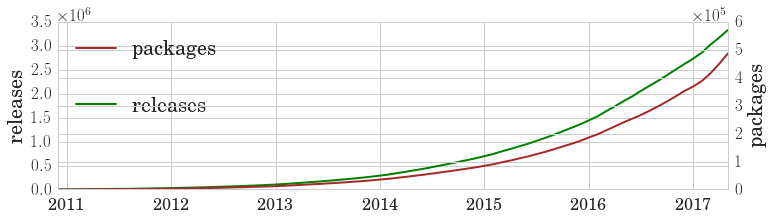

In [346]:
npm_count=npm_versions.groupby('date').count()
npm_count_packs=npm_pack_dates.groupby('date').count()

npm_count['releases']=npm_count['releases'].cumsum()
npm_count_packs['packages']=npm_count_packs['packages'].cumsum()
fig, ax1 = plt.subplots()
ax1.plot(npm_count.releases, color='green')
ax1.figure.set_size_inches(9,3)

ax1.legend(
   loc='center left',
   fontsize=20)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_ylabel('releases')
ax1.set_xlim('2010-12','2017-05')

ax2 = ax1.twinx()
ax2.plot(npm_count_packs.packages, color='brown')
ax2.set_xlim('2010-12','2017-05')
ax1.figure.set_size_inches(12,3)
ax2.set_ylabel('packages')
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.legend(
   loc='upper left',
   fontsize=20)
#ax2.set_ylim(0,500000)
#ax2.figure.savefig('../../seneca_research/SANER2018/figures/evolution_npm.pdf', bbox_inches='tight', facecolor='white')

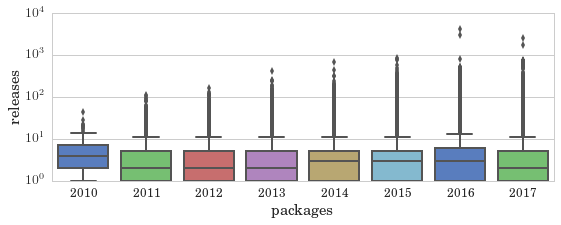

In [46]:
npm_versions_year['releases']=npm_versions_year['versions']
npm_versions_count=npm_versions_year.groupby(['package','date']).count().reset_index()
npm_versions_count['date']=npm_versions_count['date'].apply(lambda x: str(x).split('-')[0] )
ax=sns.boxplot(y='releases', x='date', data=npm_versions_count , palette="muted")
ax.set_yscale('log')
ax.figure.set_size_inches(9,3)
ax.set_xlabel('packages')
#ax.set_ylim(0,100)

# Dead code: skip

In [10]:
# f=open('../saner2018/csv/DATA_NPM_FINAL.csv','w')
# deprecateds = [line.strip() for line in open("../saner2018/csv/deprecated_npm.csv", 'r')]
# bowers = [line.strip() for line in open("../saner2018/csv/bower_npm_sim.csv", 'r')]

# f.write('name;quality;popularity;maintenance;repository;tests;issues;dependencies;dep_pro;dep_repo;first_release;size;deprecated;bower\n')
# with open('../saner2018/csv/new_data500.csv') as lines:
#     for index, line in enumerate(lines):
#         line=line.strip('\n')
#         line2=line.split(';')
#         if index==0:
#             continue
#         #dep=deprecated_npm.query('name=="'+line2[0]+'"')
#         #bower=bower_npm_similar.query('name=="'+line2[0]+'"')
#         if line2[0] in deprecateds:
#             dep=True
#         else:
#             dep=False
#         if line2[0] in bowers:
#             bower=True
#         else:
#             bower=False
#         f.write(line+';'+str(dep)+';'+str(bower)+'\n')
# f.close()
            

In [ ]:
ax=npm_packages.plot( kind="scatter", y='popularity',x='quality', linewidth=2, color='blue')
ax.figure.set_size_inches(12,4)
#scatter(impact['id'], impact['prop'], s=13, c='black')

# Empirical Analysis: Melted dataframe

In [51]:
npm_packages['use']=npm_packages['dep_repo']+npm_packages['dep_pro']

group_usage=npm_packages.groupby('use').count().loc[:,['popularity']]
group_dep=npm_packages.groupby('dependencies').count().loc[:,['quality']]




group_usage['popularity']=group_usage['popularity'].apply(lambda x: float(float(x)/2985.67))
group_dep['quality']=group_dep['quality'].apply(lambda x: float(float(x)/2985.67))

group_usage.reset_index(inplace=True)
group_dep.reset_index(inplace=True)

group_usage.rename(columns = {'use':'id','popularity':'usage'}, inplace=True)
group_dep.rename(columns = {'dependencies':'id','quality':'dependencies'}, inplace=True)

group_usage['id']=group_usage['id'].apply(int)
group_dep['id']=group_dep['id'].apply(int)

group_usage.set_index('id', inplace=True)
group_dep.set_index('id', inplace=True)



group=pd.concat([group_usage,group_dep], axis=1)
group.head()
#group.head()

,usage,dependencies
id,,
0,38.110374,34.653863
1,14.908546,19.042627
2,13.852502,13.523933
3,6.959912,9.403584
4,4.372218,6.279663


In [58]:
group['dependencies_cum']=group['usage'].cumsum()
group.tail()

,usage,dependencies,dependencies_cum
id,,,
309400,0.000335,NaN,99.998660
320400,0.000335,NaN,99.998995
345500,0.000335,NaN,99.999330
434000,0.000335,NaN,99.999665
498300,0.000335,NaN,100.000000


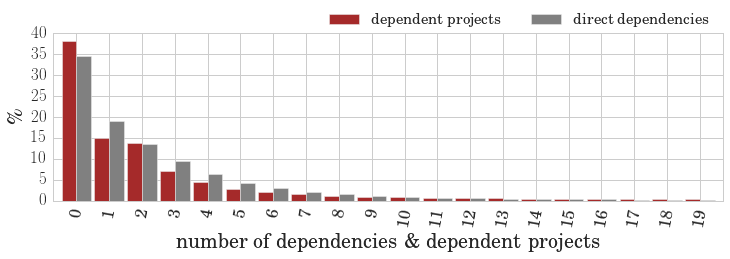

In [59]:
ax=group.head(20).plot(kind='bar', color=['brown','gray','purple'], y=['usage','dependencies'], width=0.9)
ax.set_ylabel('\%')
ax.set_xlabel('number of dependencies \& dependent projects')
ax.legend(['dependent projects','direct dependencies'], loc='upper right', 
          bbox_to_anchor=(1, 1.2), fontsize=15,ncol=3, fancybox=True, shadow=True)
plt.xticks(rotation='80')
#ax.set_yscale('log')
ax.figure.set_size_inches(12,3)
ax.figure.savefig('../../seneca_research/SANER2018/figures/dep_projects.pdf', bbox_inches='tight', facecolor='white')

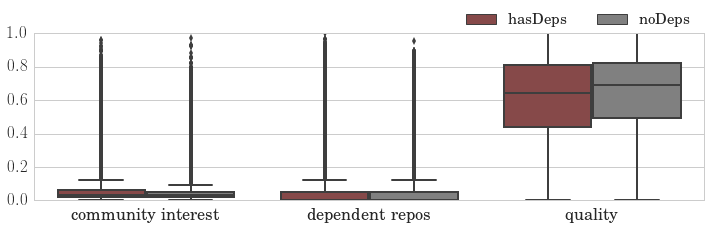

In [21]:
# Melted a new dataframe
npm_packages['hasDependencies']=npm_packages['dependencies'].apply(lambda x: 'hasDeps' if int(x)>0
                                                                              else 'noDeps')

npm_packages_only3=npm_packages.loc[:,['popularity','requiredBy','quality','hasDependencies']]

#npm_packages_only3=npm_packages_only3.query('first_release > 2000')

#npm_packages_only3['first_release']=npm_packages_only3.first_release.apply(lambda x: float(x/2527.0))
npm_packages_only3.rename(columns = {'requiredBy':'dependent repos', 'popularity':'community interest'}, inplace=True)


# npm_packages_only3['popularity']= npm_packages_only3['popularity'].apply(lambda x: '0' if x==0
#                                                    else '4-5' if x==1
#                                                    else str(x/2)[2]+'-'+str((x/2)+0.1)[2])
#npm_packages_only3['maintenance']= npm_packages_only3['maintenance'].apply(lambda x: str(x/2)[2])#+'-'+str((x/2)+0.1)[2])

#melt the dataframe
npm_packages_only3=pd.melt(npm_packages_only3, id_vars=['hasDependencies'])# value_vars=['quality','tests'])
npm_packages_only3=npm_packages_only3.rename(columns = {'variable':'metric'})
ax = sns.boxplot(y="value", x="metric", hue="hasDependencies", hue_order=['hasDeps', 'noDeps'], data=npm_packages_only3, palette=['brown','gray','green','blue'], saturation=0.5)#, split=True)#, order=order)    
ax.set_ylabel('')
ax.set_xlabel('')
#ax.set_yscale('log')
ax.figure.set_size_inches(12,3)
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=15,ncol=3, fancybox=True, shadow=True)
ax.figure.savefig('../../seneca_research/SANER2018/figures/qualityPopularityDependencies.pdf', bbox_inches='tight', facecolor='white')

In [41]:
npm_packages_only3.head()

,hasDependencies,metric,value
0,noDeps,testing,0.000000
1,noDeps,testing,0.850000
2,hasDeps,testing,0.383667
3,noDeps,testing,0.000000
4,noDeps,testing,0.600000


C:\Users\Ahmed\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


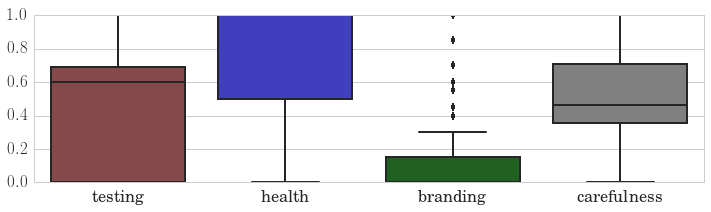

In [5]:
# Melted a new dataframe
npm_packages_only3=npm_packages.loc[:,['testing','health','branding','carefulness','hasDependencies']]

#npm_packages_only3=npm_packages_only3.query('first_release > 2000')

#npm_packages_only3['first_release']=npm_packages_only3.first_release.apply(lambda x: float(x/2527.0))
#npm_packages_only3.rename(columns = {'popularity':'community interest','requiredBy':'dependent repos'}, inplace=True)

#for column in npm_packages_only3:
#    npm_packages_only3[column]= npm_packages_only3[column].apply(float)

# npm_packages_only3['popularity']= npm_packages_only3['popularity'].apply(lambda x: '0' if x==0
#                                                    else '4-5' if x==1
#                                                    else str(x/2)[2]+'-'+str((x/2)+0.1)[2])
#npm_packages_only3['maintenance']= npm_packages_only3['maintenance'].apply(lambda x: str(x/2)[2])#+'-'+str((x/2)+0.1)[2])

#melt the dataframe
npm_packages_only3=pd.melt(npm_packages_only3, id_vars=['hasDependencies'])# value_vars=['quality','tests'])
npm_packages_only3=npm_packages_only3.rename(columns = {'variable':'metric'})
ax = sns.boxplot(y="value", x="metric",  hue_order=['hasDeps', 'noDeps'],  data=npm_packages_only3, palette=['brown','blue','green','gray'], saturation=0.5)#, split=True)#, order=order)    
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=15,ncol=3, fancybox=True, shadow=True)
ax.figure.set_size_inches(12,3)
#ax.figure.savefig('../../seneca_research/SANER2018/figures/quality.pdf', bbox_inches='tight', facecolor='white')

In [49]:
cliffsDelta(npm_packages.query('dependencies==0').carefulness,npm_packages.query('dependencies>0').carefulness)

d=-0.0373510852022 False


False

# Empirical Analysis: Main dataframe

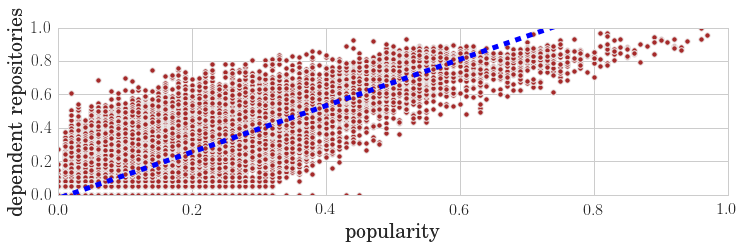

In [11]:
import math
npm_packages['requiredBy']=npm_packages.dep_repo.apply(lambda x: float((math.log(int(x)))/(math.log(468000))) if x>1
                                                      else 0)
#npm_packages['requiredBy']=npm_packages.dep_repo.apply(lambda x: float(x/468000.0))
#npm_packages['age']=npm_packages.first_release.apply(lambda x: float(x/2527.0))

# ax=npm_packages.sort_values(['popularity'],ascending=False).head(20).plot( kind='bar', color=['brown','gray','purple'],
#                                                                           y=['requiredBy','popularity'], width=0.9)

df=npm_packages.sort_values(['popularity'],ascending=False)
ax=df.plot( s=30, kind="scatter", y='requiredBy',x='popularity', linewidth=1, color='brown')

#ax.legend(['required by repositories','developer community interest'], loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=15,ncol=3, fancybox=True, shadow=True)

z = np.polyfit(df['popularity'], df['requiredBy'], 1)
p = np.poly1d(z)
plt.plot(df['popularity'],p(df['popularity']),"blue", linestyle='--', linewidth=5)

ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.set_ylabel('dependent repositories')
ax.set_xlabel('popularity')


ax.figure.set_size_inches(12,3)
ax.figure.savefig('../../seneca_research/SANER2018/figures/popularity.png', bbox_inches='tight', facecolor='white')

In [6]:
#get pearson r correlation
tab=[]
tab2=[]

# for index, orde in enumerate(order):
#     tab.append(npm_packages_only3.query('popular=="'+orde+'" and metric=="tests"').value.median())
#     tab2.append(index)
# scipy.stats.pearsonr(tab2,tab)
scipy.stats.spearmanr(npm_packages.branding,
                     npm_packages.popularity)

(0.19280936576475463, 0.0)

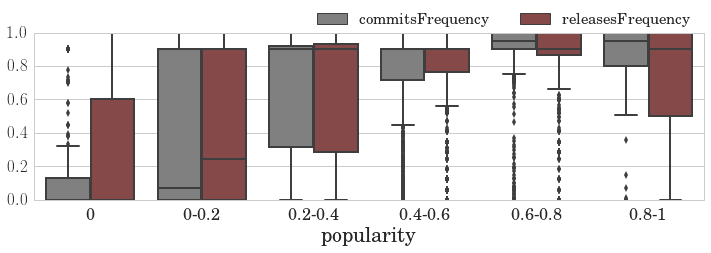

In [6]:
npm_packages['popular']= npm_packages['popularity'].apply(lambda x: '0' if x==0
                                                          else '0-0.2' if x <= 0.2 and x>0
                                                          else '0.2-0.4' if x <=0.4 and x > 0.2
                                                          else '0.4-0.6' if x <=0.6 and x > 0.4
                                                          else '0.6-0.8' if x <=0.8 and x > 0.6
                                                          else '0.8-1')

npm_packages_only3=npm_packages.loc[:,['commitsFrequency','releasesFrequency', 'popular']]
order=['0','0-0.2', '0.2-0.4','0.4-0.6','0.6-0.8', '0.8-1']

npm_packages_only3=pd.melt(npm_packages_only3, id_vars=['popular'], value_vars=['commitsFrequency','releasesFrequency'])
npm_packages_only3=npm_packages_only3.rename(columns = {'variable':'metric'})
ax = sns.boxplot(y="value", x="popular", hue='metric',
                    data=npm_packages_only3,
                    palette=['gray','brown'], saturation=0.5, order=order)

#fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
#sns.violinplot(y="quality", x="popular",data=npm_packages, palette="muted", ax=axes[0], split=True, order=order)
ax.figure.set_size_inches(12,3)
ax.set_ylabel('')
ax.set_xlabel('popularity')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=15,ncol=3, fancybox=True, shadow=True)
ax.figure.savefig('../../seneca_research/SANER2018/figures/popularity_releasing_commiting.pdf', bbox_inches='tight', facecolor='white')

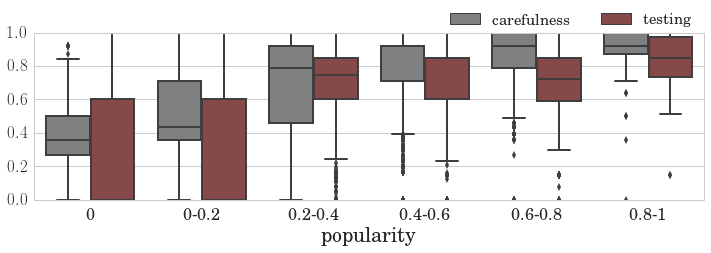

In [27]:
npm_packages['popular']= npm_packages['popularity'].apply(lambda x: '0' if x==0
                                                          else '0-0.2' if x <= 0.2 and x>0
                                                          else '0.2-0.4' if x <=0.4 and x > 0.2
                                                          else '0.4-0.6' if x <=0.6 and x > 0.4
                                                          else '0.6-0.8' if x <=0.8 and x > 0.6
                                                          else '0.8-1')

npm_packages_only3=npm_packages.loc[:,['testing','carefulness', 'popular']]
order=['0','0-0.2', '0.2-0.4','0.4-0.6','0.6-0.8', '0.8-1']

npm_packages_only3=pd.melt(npm_packages_only3, id_vars=['popular'], value_vars=['carefulness','testing'])
npm_packages_only3=npm_packages_only3.rename(columns = {'variable':'metric'})
ax = sns.boxplot(y="value", x="popular", hue='metric',
                    data=npm_packages_only3,
                    palette=['gray','brown'], saturation=0.5, order=order)

#fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
#sns.violinplot(y="quality", x="popular",data=npm_packages, palette="muted", ax=axes[0], split=True, order=order)
ax.figure.set_size_inches(12,3)
ax.set_ylabel('')
ax.set_xlabel('popularity')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=15,ncol=3, fancybox=True, shadow=True)
ax.figure.savefig('../../seneca_research/SANER2018/figures/popularity_tests.pdf', bbox_inches='tight', facecolor='white')

In [40]:
tab={}
for y in npm_packages_only3.query('metric=="tests"').value.values:
    try:
        tab[str(y)]=tab[str(y)]+1
    except:
        tab[str(y)]=0

In [36]:
scipy.stats.normaltest(tab.values())

NormaltestResult(statistic=4384.149511083453, pvalue=0.0)

In [23]:
# Nova Test
tab=[]
for index, orde in enumerate(order):
    tab.append(npm_packages_only3.query('popular=="'+orde+'" and metric=="carefulness"').value)
m=scipy.stats.f_oneway(tab[0],tab[1],tab[2],tab[3],tab[4],tab[5])
print(m)

F_onewayResult(statistic=1382.0013451639991, pvalue=0.0)


In [16]:
# Cliff's Delta
from __future__ import division
 
def cliffsDelta(lst1,lst2,
                dull = [0.147, # small
                        0.33,  # medium
                        0.474 # large
                        ][0] ): 
  "Returns true if there are more than 'dull' differences"
  m, n = len(lst1), len(lst2)
  lst2 = sorted(lst2)
  j = more = less = 0
  for repeats,x in runs(sorted(lst1)):
    while j <= (n - 1) and lst2[j] <  x: 
      j += 1
    more += j*repeats
    while j <= (n - 1) and lst2[j] == x: 
      j += 1
    less += (n - j)*repeats
  d= (more - less) / (m*n)
  f=abs(d)  > dull
  print("d="+str(d)+' '+str(f))
  return abs(d)  > dull
   
def runs(lst):
  "Iterator, chunks repeated values"
  for j,two in enumerate(lst):
    if j == 0:
      one,i = two,0
    if one!=two:
      yield j - i,one
      i = j
    one=two
  yield j - i + 1,two
  
def _cliffsDelta():
  "demo function"
  lst1=[1,2,3,4,5,6,7]
  for r in [1.01,1.1,1.21, 1.5, 2]:
    lst2=map(lambda x: x*r,lst1)
    #return lst2
    print lst2,cliffsDelta(lst1,lst2) # should return False

In [194]:
for ord in order:
    tmp_df=npm_packages.query('popular=="'+ord+'"').reset_index().loc[:,['carefulness','tests']]
    print(ord)
    cliffsDelta(tmp_df.carefulness, tmp_df.tests)

0
d=0.358878036564 True
0-0.2
d=0.166687967771 True
0.2-0.4
d=0.130258412259 False
0.4-0.6
d=0.261023435715 True
0.6-0.8
d=0.49375029455 True
0.8-1
d=0.394079200308 True


In [96]:
#get pearson r correlation
tab=[]
tab2=[]

# for index, orde in enumerate(order):
#     tab.append(npm_packages_only3.query('popular=="'+orde+'" and metric=="tests"').value.median())
#     tab2.append(index)
# scipy.stats.pearsonr(tab2,tab)
scipy.stats.pearsonr(npm_packages.query('popularity>0').tests,
                     npm_packages.query('popularity>0').popularity)

(0.19961349956485333, 0.0)

In [77]:
#Man whitney you test
for index, orde in enumerate(order):
    
    print(orde,scipy.stats.mannwhitneyu(npm_packages_only3.query('popular=="'+orde+'" and metric=="carefulness"').value,
                                   npm_packages_only3.query('popular=="'+orde+'" and metric=="tests"').value,
                                   use_continuity=True, alternative='greater'))

('0', MannwhitneyuResult(statistic=89529.0, pvalue=1.2781171990276064e-17))
('0-0.2', MannwhitneyuResult(statistic=48650018457.5, pvalue=0.0))
('0.2-0.4', MannwhitneyuResult(statistic=30513080.0, pvalue=1.3583122260046769e-99))
('0.4-0.6', MannwhitneyuResult(statistic=1576002.5, pvalue=3.0403883147584324e-53))
('0.6-0.8', MannwhitneyuResult(statistic=142630.0, pvalue=1.9342902082450681e-37))
('0.8-1', MannwhitneyuResult(statistic=1813.0, pvalue=0.00025599891947848224))


# Maintenance

In [7]:
maintainability=npm_packages.query('issues!=0')
anti_maint=npm_packages.query('issues==0')
main_dist=pd.read_csv('../saner2018/csv/maintenance_distr.csv',
                                sep=';', dtype=object, index_col='name')
maintainability=pd.concat([maintainability,main_dist], axis=1)
maintainability['fixingIssues']=maintainability['issuesTime'].apply(float)
len(maintainability)


150351

In [8]:
maintainability['type']='has issues'
anti_maint['type']='zero issues'
#issues_age = pd.concat(maintainability.loc[:,['type','last_release']], anti_maint.loc[:,['type','last_release']])
issues_age=maintainability.loc[:,['releases','type','last_release','size','first_release']].append(anti_maint.loc[:,['releases','type','last_release','size','first_release']])
# issues_age['size']=issues_age['size'].apply(lambda x: float(x/1405091.0))
# issues_age['last_release']=issues_age['last_release'].apply(lambda x: float(x/2491.0))
# issues_age['first_release']=issues_age['first_release'].apply(lambda x: float(x/2533.0))
len(issues_age)

C:\Users\Ahmed\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


298568

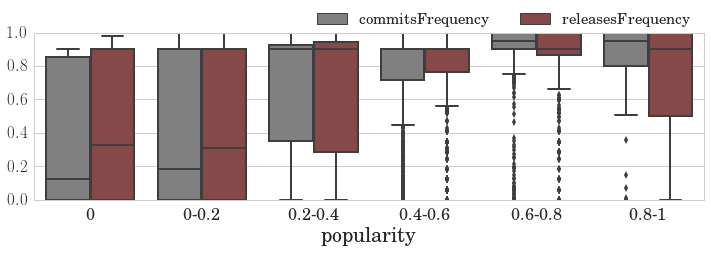

In [10]:
maintainability['popular']= maintainability['popularity'].apply(lambda x: '0' if x==0
                                                          else '0-0.2' if x <= 0.2 and x>0
                                                          else '0.2-0.4' if x <=0.4 and x > 0.2
                                                          else '0.4-0.6' if x <=0.6 and x > 0.4
                                                          else '0.6-0.8' if x <=0.8 and x > 0.6
                                                          else '0.8-1')

npm_packages_only3=maintainability.loc[:,['commitsFrequency','releasesFrequency', 'popular']]
order=['0','0-0.2', '0.2-0.4','0.4-0.6','0.6-0.8', '0.8-1']

npm_packages_only3=pd.melt(npm_packages_only3, id_vars=['popular'], value_vars=['commitsFrequency','releasesFrequency'])
npm_packages_only3=npm_packages_only3.rename(columns = {'variable':'metric'})
ax = sns.boxplot(y="value", x="popular", hue='metric',
                    data=npm_packages_only3,
                    palette=['gray','brown'], saturation=0.5, order=order)

#fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
#sns.violinplot(y="quality", x="popular",data=npm_packages, palette="muted", ax=axes[0], split=True, order=order)
ax.figure.set_size_inches(12,3)
ax.set_ylabel('')
ax.set_xlabel('popularity')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=15,ncol=3, fancybox=True, shadow=True)
ax.figure.savefig('../../seneca_research/SANER2018/figures/popularity_releasing_commiting.pdf', bbox_inches='tight', facecolor='white')

In [45]:
maintainability['commitsGroup']=maintainability['commitsFrequency'].apply(lambda x: 'commit score under the mean' if float(x)<0.42
                                                               else 'commit score  above the mean')

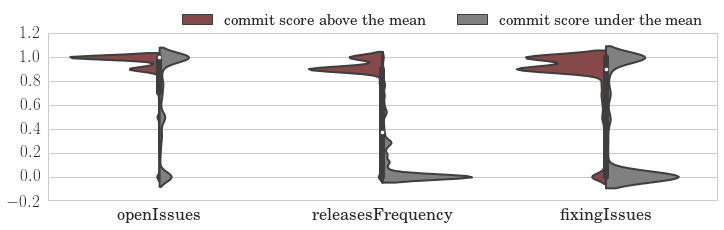

In [46]:
npm_packages_only3=maintainability.loc[:,['openIssues','commitsGroup','releasesFrequency','fixingIssues']]
#fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
#npm_packages_only3=npm_packages_only3.rename(columns = {'releasing':'releaseFrequency'})

npm_packages_only3=pd.melt(npm_packages_only3, id_vars=['commitsGroup'])# value_vars=['quality','tests'])
npm_packages_only3=npm_packages_only3.rename(columns = {'variable':'metric'})
ax = sns.violinplot(y="value", split=True, x="metric", hue='commitsGroup', data=npm_packages_only3, palette=['brown','gray','green','gray','orange'], saturation=0.5)#, split=True)#, order=order)    
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=15,ncol=3, fancybox=True, shadow=True)
ax.figure.set_size_inches(12,3)
ax.figure.savefig('../../seneca_research/SANER2018/figures/commits_mean.pdf', bbox_inches='tight', facecolor='white')

In [37]:
cliffsDelta(maintainability.query('commitsFrequency >0.25').releasesFrequency,
                         maintainability.query('commitsFrequency <=0.25').releasesFrequency)

d=0.920640715318 True


True

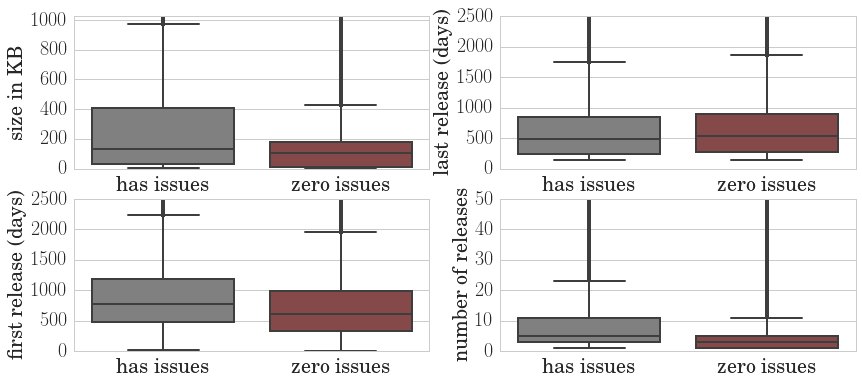

In [16]:
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

fig, axes = plt.subplots(2,2, sharex=False, sharey=False)

ax=sns.boxplot(y="size", x="type",
                    data=issues_age,
                    palette=['gray','brown'], saturation=0.5,ax=axes[0][0])
ax.set_ylim(0,1024)
ax.set_xlabel('')
ax.set_ylabel('size in KB')
# ax.figure.savefig('../../seneca_research/SANER2018/figures/size_issues.pdf', bbox_inches='tight', facecolor='white')


ax=sns.boxplot(y="last_release", x="type",
                    data=issues_age,
                    palette=['gray','brown'], saturation=0.5 ,ax=axes[0][1])
ax.set_ylabel('last release (days)')
ax.set_ylim(0,2500)
ax.set_xlabel('')
# ax.figure.savefig('../../seneca_research/SANER2018/figures/last_releases.pdf', bbox_inches='tight', facecolor='white')


ax=sns.boxplot(y="first_release", x="type",
                    data=issues_age,
                    palette=['gray','brown'], saturation=0.5,ax=axes[1][0])
ax.set_ylabel('first release (days)')
ax.set_ylim(0,2500)
ax.set_xlabel('')
# ax.figure.savefig('../../seneca_research/SANER2018/figures/first_releases.pdf', bbox_inches='tight', facecolor='white')


ax=sns.boxplot(y="releases", x="type",
                    data=issues_age,
                    palette=['gray','brown'], saturation=0.5, ax=axes[1][1])
ax.set_ylabel('number of releases')
ax.set_ylim(0,50)
ax.set_xlabel('')
#ax.figure.savefig('../../seneca_research/SANER2018/figures/releases_issues.pdf', bbox_inches='tight', facecolor='white')
     
ax.figure.set_size_inches(14,6)
ax.figure.savefig('../../seneca_research/SANER2018/figures/issues_age_size.pdf', bbox_inches='tight', facecolor='white')


In [30]:
scipy.stats.ranksums(issues_age.query('type=="has issues"')['size'], 
                         issues_age.query('type=="zero issues"')['size'])
                                   #use_continuity=True, alternative='two-sided')

RanksumsResult(statistic=97.061729621803025, pvalue=0.0)

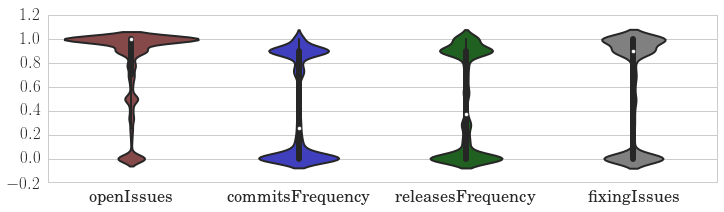

In [45]:
npm_packages_only3=maintainability.loc[:,['openIssues','commitsFrequency','releasesFrequency','fixingIssues']]
#fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

npm_packages_only3=pd.melt(npm_packages_only3)#, id_vars=['name','popularity'], value_vars=['quality','tests'])
npm_packages_only3=npm_packages_only3.rename(columns = {'variable':'metric'})
ax = sns.violinplot(y="value", x="metric", data=npm_packages_only3, palette=['brown','blue','green','gray','orange'], saturation=0.5)#, split=True)#, order=order)    
ax.set_ylabel('')
ax.set_xlabel('')

ax.figure.set_size_inches(12,3)
ax.figure.savefig('../../seneca_research/SANER2018/figures/maintenance.pdf', bbox_inches='tight', facecolor='white')

In [ ]:
npm_packages_only3=maintainability.loc[:,['openIssues','commitsFrequency','releasesFrequency','fixingIssues']]
npm_packages_only3['commits']

In [133]:
commitsFrequency=np.array(maintainability.head(7000).commitsFrequency.values, dtype=float)
releasesFrequency=np.array(maintainability.head(7000).releasesFrequency.values, dtype=float)
#Man whitney you test
scipy.stats.mannwhitneyu(commitsFrequency, 
                         releasesFrequency,
                                   use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=23417901.0, pvalue=4.1771595656488901e-12)

C:\Users\Ahmed\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


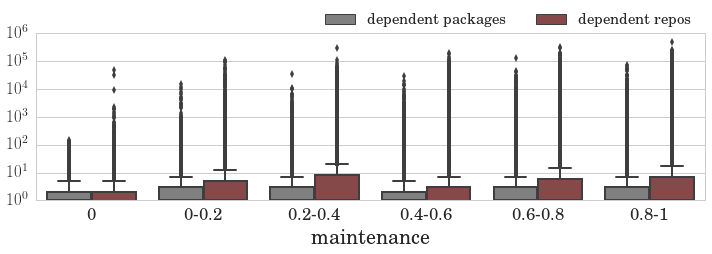

In [170]:
maintainability['maintainability']= maintainability['maintenance'].apply(lambda x: '0' if x==0
                                                          else '0-0.2' if x <= 0.2 and x>0
                                                          else '0.2-0.4' if x <=0.4 and x > 0.2
                                                          else '0.4-0.6' if x <=0.6 and x > 0.4
                                                          else '0.6-0.8' if x <=0.8 and x > 0.6
                                                          else '0.8-1')

npm_packages_only3=maintainability.loc[:,['dep_pro','dep_repo', 'maintainability']]
order=['0','0-0.2', '0.2-0.4','0.4-0.6','0.6-0.8', '0.8-1']
npm_packages_only3=npm_packages_only3.rename(columns = {'dep_pro':'dependent packages'})
npm_packages_only3=npm_packages_only3.rename(columns = {'dep_repo':'dependent repos'})


npm_packages_only3=pd.melt(npm_packages_only3, id_vars=['maintainability'], value_vars=['dependent packages','dependent repos'])
npm_packages_only3=npm_packages_only3.rename(columns = {'variable':'metric'})
ax = sns.boxplot(y="value", x="maintainability", hue='metric',
                    data=npm_packages_only3,
                    palette=['gray','brown','green','blue','orange'], saturation=0.5, order=order)

#fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
#sns.violinplot(y="quality", x="popular",data=npm_packages, palette="muted", ax=axes[0], split=True, order=order)
ax.figure.set_size_inches(12,3)
ax.set_ylabel('')
ax.set_xlabel('maintenance')
ax.set_yscale('log')

ax.legend(loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=15,ncol=3, fancybox=True, shadow=True)

ax.figure.savefig('../../seneca_research/SANER2018/figures/maintenance_popularity.pdf', bbox_inches='tight', facecolor='white')

In [181]:
# ANova Test
tab=[]
for index, orde in enumerate(order):
    tab.append(npm_packages_only3.query('maintainability=="'+orde+'" and metric=="dependent packages"').value.mean())
#scipy.stats.kruskal(tab[2],tab[4],tab[5])
tab


[2.0896603631573996,
 9.24624770020335,
 24.792716808890653,
 14.080033760228982,
 79.08828042969066,
 35.035122120015]

# Forget about this part, this was the early analysis

In [ ]:
# npm_packages['tests']= npm_packages['tests'].apply(lambda x: '0' if x==0
#                                                    else '4-5' if x==1
#                                                    else str(x/2)[2]+'-'+str((x/2)+0.1)[2])

order=['0','0-0.2', '0.2-0.4','0.4-0.6','0.6-0.8', '0.8-1']
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
#sns.violinplot(y="quality", x="tests",data=npm_packages, palette="muted", hue="deprecated",ax=axes[0], split=True, order=order)
ax=sns.boxplot(y="quality", x="tests",data=maintainability, palette="muted", hue="bower",ax=axes[0], order=order)
ax.legend(loc='upper left')
#ax.figure.set_size_inches(12,4)
#ax = sns.violinplot(y="maintenance", x="tests",data=npm_packages, palette="muted",hue="deprecated", ax=axes[1], split=True, order=order)
ax = sns.boxplot(y="maintenance", x="tests",data=npm_packages, palette="muted",hue="bower", ax=axes[1], order=order)
ax.legend(loc='upper left')
#ax = sns.violinplot(y="popularity", x="tests",data=npm_packages, palette="muted", hue="deprecated",ax=axes[2], split=True, order=order)
ax = sns.boxplot(y="popularity", x="tests",data=npm_packages, palette="muted", hue="bower",ax=axes[2], order=order)
ax.figure.set_size_inches(15,10)

In [ ]:
#npm_packages['tests']= npm_packages['tests'].apply(lambda x: str(x/2)[2]+'-'+str((x/2)+0.1)[2])
#npm_packages['maintenance2']= npm_packages['maintenance'].apply(lambda x: str(x/2)[2]+'-'+str((x/2)+0.1)[2])
order=['0','0-0.2', '0.2-0.4','0.4-0.6','0.6-0.8', '0.8-1']
fig, axes = plt.subplots(5, 1, sharex=True, sharey=True)
ax=sns.boxplot(y="dep_repo", x="tests",data=npm_packages, palette="muted", ax=axes[0], order=order)
#ax=sns.violinplot(y="dep_repo", x="tests",data=npm_packages, hue="bower", palette="muted", ax=axes[0], split=True, order=order)

ax.set_ylabel('dep repositories')
ax = sns.boxplot(y="dep_pro", x="tests",data=npm_packages, palette="muted", ax=axes[1],  order=order)
#ax = sns.violinplot(y="dep_pro", x="tests",data=npm_packages, palette="muted", hue="bower", ax=axes[1], split=True, order=order)

ax.set_ylabel('dep projects')
ax = sns.boxplot(y="size", x="tests",data=npm_packages, palette="muted", ax=axes[2],  order=order)
#ax = sns.violinplot(y="size", x="tests",data=npm_packages, palette="muted",hue="bower", ax=axes[2], split=True, order=order)

ax = sns.boxplot(y="dependencies", x="tests",data=npm_packages, palette="muted", ax=axes[3],  order=order)
#ax = sns.violinplot(y="dependencies", x="tests",data=npm_packages, palette="muted", hue="bower", ax=axes[3], split=True, order=order)

#ax = sns.boxplot(y="releases", x="tests",data=npm_packages, palette="muted", ax=axes[4],  order=order)


ax.figure.set_size_inches(16,12)
#ax.set_yscale('log')
ax.set_ylim(-1000,3000)


In [ ]:
ax=npm_packages.groupby('tests').count().plot(kind='bar', y="name")

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
order=['0','0-1', '1-2','2-3','3-4', '4-5']
ax = sns.violinplot(y="age", x="tests",data=npm_packages, palette="muted", ax=axes[0], split=True, order=order)
ax.set_ylabel('age')
ax = sns.violinplot(y="age", x="popular",data=npm_packages, palette="muted", ax=axes[1], split=True, order=order)
ax.set_ylabel('age')
ax.figure.set_size_inches(12,4)

# Deprecated Packages

In [29]:
#768 = have deprecated in status
#2290 = after description
#836 = from what we have now
deprecated=npm_packages.query('deprecated=="True"')
deprecated.drop(['depd'], inplace=True)
#deprecated.sort_values(['dep_repo'], ascending=False)

C:\Users\Ahmed\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


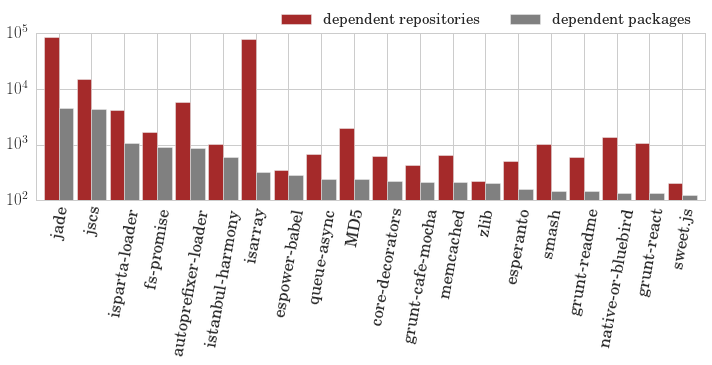

In [222]:

#fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
ax=deprecated.sort_values(['dep_pro'],ascending=False).head(20).plot(kind='bar', color=['brown','gray','purple'],
                                                                          y=['dep_repo','dep_pro'], width=0.9)
ax.legend(['dependent repositories','dependent packages'], loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=15,ncol=3, fancybox=True, shadow=True)
plt.xticks(rotation='80')

ax.set_yscale('log')
ax.figure.set_size_inches(12,3)
ax.figure.savefig('../../seneca_research/SANER2018/figures/deprecated_packages.pdf', bbox_inches='tight', facecolor='white')

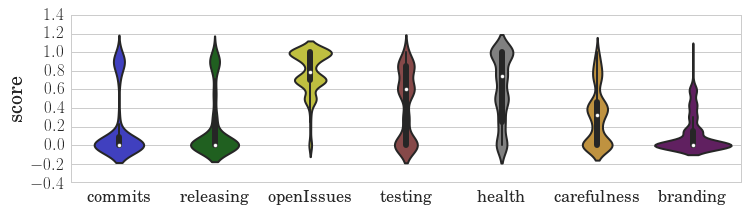

In [31]:
deprecated=deprecated.rename(columns = {'commitsFrequency':'commits'})
deprecated=deprecated.rename(columns = {'releasesFrequency':'releasing'})

df=deprecated.loc[:,['commits','releasing','openIssues','testing','health','carefulness','branding']]
df=pd.melt(df) #,id_vars=['deprecated'])#, value_vars=['quality','tests'])
df=df.rename(columns = {'variable':'metric'})
#order=['0','0-0.2', '0.2-0.4','0.4-0.6','0.6-0.8', '0.8-1']
#fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
ax=sns.violinplot(y="value", x='metric', palette=['blue','green','yellow','brown','gray','orange','purple'], saturation=0.5, data=df)
ax.set_xlabel( '')
# ax=sns.violinplot(y="commitsFrequency",data=npm_packages.query('deprecated=="False"'), palette=["brown"], ax=axes[1])
# ax.legend(loc='upper left')
# ax = sns.boxplot(y="maintenance", x="popular",data=deprecated, palette="muted",hue="deprecated", ax=axes[1], order=order)
# ax.legend(loc='upper left')
# ax = sns.boxplot(y="popularity", x="popular",data=deprecated, palette="muted", hue="deprecated",ax=axes[2], order=order)
#ax.set_yscale('log')
ax.figure.set_size_inches(12,3)
ax.set_ylabel('score')
ax.figure.savefig('../../seneca_research/SANER2018/figures/deprecated.pdf', bbox_inches='tight', facecolor='white')


In [309]:
deprecated=npm_packages.query('deprecated=="True"')
deprecated.sort_values(['openIssues'], ascending=False).releases.head()

noder.io-app         2.0
linq-ts             18.0
generator-vinoga     9.0
generator-sapui5     2.0
less-watch           4.0
Name: releases, dtype: float64

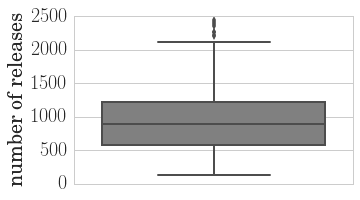

In [328]:
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 24}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

# ax=sns.boxplot(y="size", x="type",
#                     data=issues_age,
#                     palette=['gray','brown'], saturation=0.5)
# ax.set_ylim(0,1024)
# ax.set_xlabel('')
# ax.set_ylabel('size in KB')
# ax.figure.savefig('../../seneca_research/SANER2018/figures/size_issues.pdf', bbox_inches='tight', facecolor='white')


# ax=sns.boxplot(y="last_release", x="type",
#                     data=issues_age,
#                     palette=['gray','brown'], saturation=0.5)
# ax.set_ylabel('last release (days)')
# ax.set_ylim(0,2500)
# ax.set_xlabel('')
# ax.figure.savefig('../../seneca_research/SANER2018/figures/last_releases.pdf', bbox_inches='tight', facecolor='white')


# ax=sns.boxplot(y="first_release", x="type",
#                     data=issues_age,
#                     palette=['gray','brown'], saturation=0.5)
# ax.set_ylabel('first release (days)')
# ax.set_ylim(0,2500)
# ax.set_xlabel('')
# ax.figure.savefig('../../seneca_research/SANER2018/figures/first_releases.pdf', bbox_inches='tight', facecolor='white')


ax=sns.boxplot(y="last_release",
                    data=deprecated,
                    palette=['gray','brown'], saturation=0.5)
ax.set_ylabel('number of releases')
ax.set_xlabel('')
ax.figure.set_size_inches(5,3)


In [356]:
deprecated.carefulness.describe()

# Bower packages

In [421]:
#bower=npm_packages.query('bower=="True"')
npm_packages['npm']=''

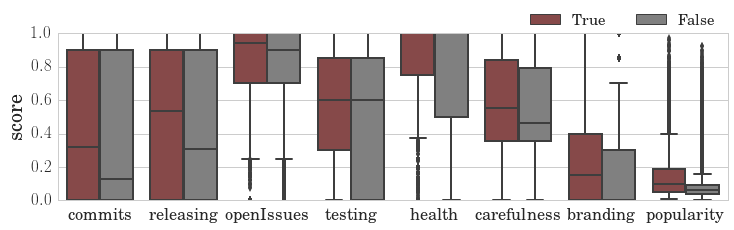

In [33]:
npm_packages=npm_packages.rename(columns = {'commitsFrequency':'commits'})
npm_packages=npm_packages.rename(columns = {'releasesFrequency':'releasing'})

df=npm_packages.query('dep_repo>0 and dep_pro>0').loc[:,['commits','releasing','openIssues','testing','health','carefulness','branding','bower','popularity']]
#df=df.rename(columns = {'variable':'metric', })
df=pd.melt(df,id_vars=['bower'])#, value_vars=['quality','tests'])
df=df.rename(columns = {'variable':'metric'})
#order=['0','0-0.2', '0.2-0.4','0.4-0.6','0.6-0.8', '0.8-1']
#fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
ax=sns.boxplot(y="value", x='metric', hue='bower', hue_order=['True', 'False'],  palette=['brown','gray','blue','green','yellow','orange','purple'], saturation=0.5, data=df)
ax.set_xlabel( '')
# ax=sns.violinplot(y="commitsFrequency",data=npm_packages.query('deprecated=="False"'), palette=["brown"], ax=axes[1])
# ax.legend(loc='upper left')
# ax = sns.boxplot(y="maintenance", x="popular",data=deprecated, palette="muted",hue="deprecated", ax=axes[1], order=order)
# ax.legend(loc='upper left')
# ax = sns.boxplot(y="popularity", x="popular",data=deprecated, palette="muted", hue="deprecated",ax=axes[2], order=order)
#ax.set_yscale('log')
ax.figure.set_size_inches(12,3)
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=15,ncol=3, fancybox=True, shadow=True)
ax.set_ylabel('score')
ax.figure.savefig('../../seneca_research/SANER2018/figures/bower.pdf', bbox_inches='tight', facecolor='white')

In [59]:
len(npm_packages.query('bower=="True"'))/len(npm_packages)

0.06768999922965364

In [51]:
for x in ['commits','releasing','openIssues','tests','size','health','carefulness','branding','popularity','first_release','dep_repo']:
    print(x,cliffsDelta(npm_packages.query('bower=="True" and dep_repo>0')[x],npm_packages.
                        query('bower=="False" and dep_repo>0')[x]))
    #print(x,scipy.stats.ranksums(npm_packages.query('bower=="True"')[x],npm_packages.query('bower=="False"')[x]))

d=0.0407607041912 False
('commits', False)
d=0.0404676077933 False
('releasing', False)
d=0.118110138395 False
('openIssues', False)
d=0.0604615792816 False
('tests', False)
d=0.32188684464 True
('size', True)
d=0.181553463366 True
('health', True)
d=0.114059608517 False
('carefulness', False)
d=0.13609973818 False
('branding', False)
d=0.330305244209 True
('popularity', True)
d=0.187258671948 True
('first_release', True)
d=0.235938264367 True
('dep_repo', True)


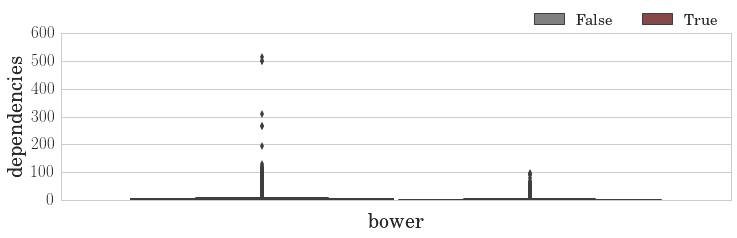

In [447]:
npm_packages['popular']= npm_packages['tests'].apply(lambda x: '0' if x==0
                                                          else '0-0.2' if x <= 0.2 and x>0
                                                          else '0.2-0.4' if x <=0.4 and x > 0.2
                                                          else '0.4-0.6' if x <=0.6 and x > 0.4
                                                          else '0.6-0.8' if x <=0.8 and x > 0.6
                                                          else '0.8-1')

#npm_packages_only3=npm_packages.loc[:,['tests','carefulness', 'popular']]
#order=['0','0-0.2', '0.2-0.4','0.4-0.6','0.6-0.8', '0.8-1']
#df=npm_packages.loc[:,['commits','releasing','openIssues','tests','health','carefulness','branding','npm','bower']]

#npm_packages_only3=pd.melt(npm_packages_only3, id_vars=['popular'], value_vars=['carefulness','tests'])
#npm_packages_only3=npm_packages_only3.rename(columns = {'variable':'metric'})
ax = sns.boxplot( y='dependencies', x="npm", hue="bower",
                    data=npm_packages,
                    palette=['gray','brown'], saturation=0.5)#, split=True)#, ax=axes[0])#, order=order)

#fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
#sns.violinplot(y="quality", x="popular",data=npm_packages, palette="muted", ax=axes[0], split=True, order=order)
ax.figure.set_size_inches(12,3)
#ax.set_ylabel('')
ax.set_xlabel('bower')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1.2), fontsize=15,ncol=3, fancybox=True, shadow=True)
#ax.figure.savefig('../../seneca_research/SANER2018/figures/popularity_tests.pdf', bbox_inches='tight', facecolor='white')

In [380]:
for x in npm_packages:
    print(x)

last_release
quality
popularity
maintenance
tests
issues
dependencies
dep_pro
dep_repo
first_release
size
deprecated
bower
carefulness
health
branding
communityInterest
downloadsCount
downloadsAcceleration
releasesFrequency
commitsFrequency
openIssues
releases
popular


# Checking my results for Trivial packages

In [ ]:
npm_packages.sort_values(["size"], ascending=True).reset_index(drop=True).query("index>29000")['size'].head()

In [12]:
# Use the propostion that "Trivial packages paper" found: 17% ~ 29000/165960 first npm packages
sized=npm_packages.sort_values(["size"], ascending=True).reset_index(drop=True).query("index<29000")
sized['ind']=sized.index
#sized.plot(kind="scatter", x='ind', y="size")
#sized.query('index==28999')

In [ ]:
trivial=npm_packages
trivial['trivial']=npm_packages['size'].apply(lambda x: 'True' if float(x)<17
                                           else 'False')

trivial['popular']= trivial['popularity'].apply(lambda x: '0' if x==0
                                                   else '4-5' if x==1
                                                   else str(x/2)[2]+'-'+str((x/2)+0.1)[2])
order=['0','0-1', '1-2','2-3','3-4', '4-5']
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
sns.violinplot(y="quality", x="popular",data=trivial, palette="muted", hue="trivial", ax=axes[0], split=True, order=order)
ax = sns.violinplot(y="maintenance", x="popular",data=trivial, palette="muted",hue="trivial", ax=axes[1], split=True, order=order)
ax = sns.violinplot(y="tests", x="popular",data=trivial, palette="muted", hue="trivial",ax=axes[2], split=True, order=order)

ax.figure.set_size_inches(12,9)